In [71]:
%%HTML
<style>
    div.prompt {display:none}
       .container {width:90%}
</style>

In [7]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from scipy.stats import dirichlet, norm
import numpy_indexed as npi

In [333]:
class DataGenerator:
    def __init__(self, n_cells, n_cell_types, n_genes, K, epsilon=0.25):
        self.n_cells = n_cells
        self.n_cell_types = n_cell_types
        self.n_genes = n_genes
        self.K = K
        self.epsilon = epsilon

        self.graph = None
        self.coordinates = None
        self.neighbors_cell_types = None
        self.perturbation = None
        self.expression = None
        self.cell_types = None
        
        self.reset()

    def reset(self):
        self.generate_cell_caracteristics()
        self.generate_perturbation()
        self.generate_knn_graph()
        self.generate_cell_types()
        self.generate_perturbed_caracteristics()

    def generate_knn_graph(self):
        self.coordinates = np.random.uniform(size=(self.n_cells, 2))
        nn = NearestNeighbors(self.K + 1)
        nn.fit(self.coordinates)
        self.graph = nn.kneighbors(self.coordinates, self.K + 1)[1][:, 1:]
        
        self.graph_reversed = [[] for _ in range(self.n_cells)]
        for v, nbs in enumerate(self.graph):
            for u in nbs:
                self.graph_reversed[u].append(v)
        self.graph_reversed = [np.array(nbs) for nbs in self.graph_reversed]

    def generate_cell_types(self):
        self.cell_types = np.random.choice(self.n_cell_types, size=self.n_cells)
        self.neighbors_cell_types = np.zeros((self.n_cells, self.n_cell_types))
        for i in range(self.n_cells):
            cell_types, counts = np.unique(
                self.cell_types[self.graph[i]], return_counts=True
            )
            self.neighbors_cell_types[i][cell_types] = counts / self.K

    def generate_perturbation(self):
        shape = (self.n_cell_types, self.n_cell_types, self.n_genes)
        self.perturbation = np.random.normal(0, 10, size=shape)

    def generate_cell_caracteristics(self):
        shape = self.n_cell_types, self.n_genes
        self.initial_cell_carac = np.random.normal(0, 10, size=shape)

    def generate_perturbed_caracteristics(self):
        effective_perturbation = (
            self.perturbation[self.cell_types]
            * self.neighbors_cell_types[:, :, np.newaxis]
        ).sum(axis=1)

        self.effective_gene_expression = (
            self.initial_cell_carac[self.cell_types]
            + self.epsilon * effective_perturbation
        )

    def generate_gene_expression(self, epsilon=None, n_cells=None):
        # If epsilon or n_cells is given, resample accordingly without changing the
        # global latent variable about cluster mean, cluster interactions
        if n_cells is not None:
            self.n_cells = n_cells
            self.generate_knn_graph()
            self.generate_cell_types()

        if epsilon is not None:
            self.epsilon = epsilon
            self.generate_perturbed_caracteristics()

        self.observations = np.random.normal(self.effective_gene_expression, 1)
        return self.observations
    

In [449]:
"""
Potentiels bugs:
    - Variance vs std
    - rho: echange des deux premieres dimensions (i et k)
    - code immonde
"""


class GibbsSampler:
    def __init__(
        self,
        num_cells,
        num_cell_types,
        num_genes,
        sigma,
        S,
        epsilon,
        graph,
        graph_reverse,
        alpha=None,
    ):
        self.num_cells = num_cells
        self.num_cell_types = num_cell_types
        self.num_genes = num_genes
        self.epsilon = epsilon
        self.graph = graph
        self.graph_reverse = graph_reverse
        self.epsilon_up = self.epsilon / self.graph.shape[1]
        self.sigma = sigma
        self.S = S
        self.Vi = None
        self.neighbors_cell_types = None
        if alpha is None:
            alpha = np.ones(num_cell_types)
        self.alpha = alpha
        self.reset()

    def reset(self):
        self.pi = np.random.dirichlet(self.alpha)
        self.update_Z(
            np.random.choice(self.num_cell_types, p=self.pi, size=self.num_cells)
        )
        self.beta = np.random.normal(
            0, self.sigma, size=(self.num_cell_types, self.num_genes)
        )
        self.rho = np.random.normal(
            0,
            self.sigma,
            size=(self.num_cell_types, self.num_cell_types, self.num_genes),
        )
        self.log_joints = []

    def update_Z(self, Z):
        self.Z = Z.astype(int)

        # Count types
        self.n_i = np.zeros(self.num_cell_types)
        cell_types, counts = np.unique(self.Z, return_counts=True)
        self.n_i[cell_types] = counts

        # Reverse map each type l: list of cells having type l
        values, indices = npi.group_by(self.Z, np.arange(self.num_cells))
        self.Vi = [np.array([]) for _ in range(self.num_cell_types)]
        for i, v in enumerate(values):
            self.Vi[v] = indices[i]

        # For each cell v, number of neighbors of type k
        self.mvk = np.zeros((self.num_cells, self.num_cell_types))
        for i in range(self.num_cells):
            cell_types, counts = np.unique(self.Z[self.graph[i]], return_counts=True)
            self.mvk[i][cell_types] = counts

        # Count number of edge k->l (in l,k)
        self.ctype_ctype_counts = np.zeros((self.num_cell_types, self.num_cell_types))
        for l in range(self.num_cell_types):
            if len(self.Vi[l]):
                self.ctype_ctype_counts[l] = self.mvk[self.Vi[l]].sum(axis=0)

    def sample_pi(self):
        return np.random.dirichlet(self.alpha + self.n_i)

    def sample_beta(self, x):
        multipliers = self.sigma ** 2 / (self.S ** 2 + self.n_i * self.sigma ** 2)

        variances = (self.S ** 2) * multipliers
        alphas = np.array(
            [
                (x[self.Vi[i]].sum(axis=0) if len(self.Vi[i]) else 0)
                - self.epsilon_up
                * (self.rho[i, :, :] * self.ctype_ctype_counts[i, :, None]).sum(axis=0)
                for i in range(self.num_cell_types)
            ]
        )

        return np.random.normal(
            multipliers[:, None] * alphas, np.sqrt(variances)[:, None]
        )

    def sample_rho(self, x):
        self.mvk

        eta = 1.0 / (
            self.S ** 2 / self.sigma ** 2
            + self.epsilon_up ** 2
            * np.array(
                [
                    (self.mvk[self.Vi[i]] ** 2).sum(axis=0)
                    if len(self.Vi[i])
                    else np.zeros((self.num_cell_types))
                    for i in range(self.num_cell_types)
                ]
            )
        )

        t = self.epsilon_up * np.array(
            [
                [
                    np.sum(
                        (
                            self.mvk[:, k, None]
                            * (
                                x
                                - self.beta[i, None, :]
                                - self.epsilon_up
                                * np.sum(
                                    self.rho[i, self.Z[self.graph], :]
                                    * (self.Z[self.graph] != k)[:, :, None],
                                    axis=1,
                                )
                            )
                        )
                        * (self.Z == i)[:, None],
                        axis=0,
                    )
                    for k in range(self.num_cell_types)
                ]
                for i in range(self.num_cell_types)
            ]
        )

        #         for i in range(self.num_cell_types):
        #             mu[i] = self.epsilon_up * (
        #                 self.mvk[self.Vi[i]].sum(axis=0) if len(self.Vi[i]) else np.zeros((self.num_cell_types))
        #             )
        return np.random.normal(
            eta[:, :, None] * t, np.sqrt((self.S ** 2) * eta[:, :, None])
        )

    def log_pz(self, x, v, k):
        # logp(z_v = k) + constant
        term1 = (
            (
                self.beta[k]
                - x[v]
                + self.epsilon_up
                * self.rho[self.Z[v]][self.Z[self.graph[v]]].sum(axis=0)
            )
            ** 2
        ).sum()

        neighbors = self.graph_reverse[v]
        if len(neighbors):
            zw = self.Z[neighbors]
            old_zv = self.Z[v]
            self.Z[v] = k

            term2 = (
                (
                    self.beta[zw]
                    - x[neighbors]
                    + self.epsilon_up
                    * self.rho[zw[:, None], self.Z[self.graph[neighbors]], :].sum(
                        axis=1
                    )
                )
                ** 2
            ).sum()

            self.Z[v] = old_zv
        else:
            term2 = 0

        return term1 + term2

    def sample_Z(self, x):
        log_vals = np.array(
            [
                [
#                                         self._log_joint(
#                                             x, self.Z + (k - self.Z[i]) * (np.arange(self.num_cells) == i)
#                                         )
                    - self.log_pz(x, i, k) + np.log(self.pi[k])
                    for k in range(self.num_cell_types)
                ]
                for i in range(self.num_cells)
            ]
        )
        log_vals -= np.max(log_vals, axis=1)[:, None]
        probas = np.exp(log_vals) / np.sum(np.exp(log_vals), axis=1)[:, None]
        return np.array(
            [
                np.random.choice(np.arange(self.num_cell_types), p=probas[v])
                for v in range(self.num_cells)
            ]
        )

    """
        This function computes the log-joint for a specified Z, which is used while sampling Z. 
        To get the log-joint for the current value of the parameters, use log_joint
    """

    def _log_joint(self, x, Z):
        temp = np.sum(np.log(self.pi[Z]))
        loc = np.array(
            [
                self.beta[Z[v], :]
                + self.epsilon_up * np.sum(self.rho[Z[v], Z[self.graph[v]], :], axis=0)
                for v in range(self.num_cells)
            ]
        )
        return temp + np.sum(norm.logpdf(x, loc, self.S * np.ones(loc.shape)))

    def log_joint(self, x):
        return self._log_joint(x, self.Z)

    def train_(self, num_epochs, x):
        for _ in range(num_epochs):
            self.update_Z(self.sample_Z(x))
            self.pi = self.sample_pi()
            self.beta = self.sample_beta(x)
            self.rho = self.sample_rho(x)
            self.log_joints.append(self.log_joint(x))

    def train(self, num_epochs, x):
        for _ in range(num_epochs):
            self.update_Z(self.sample_Z(x))
            self.pi = self.sample_pi()
            self.beta = self.sample_beta(x)
            self.rho = self.sample_rho(x)
            self.log_joints.append(self.log_joint(x))

    def plot(self):
        plt.plot(np.arange(len(self.log_joints)), self.log_joints)

In [541]:
n_cells = 500
n_cell_types = 3
n_genes = 6
K = 3
epsilon = 0.73

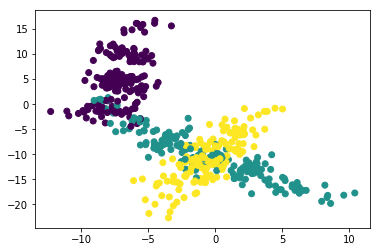

In [542]:
np.random.seed(2)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
expression = dg.generate_gene_expression(epsilon, n_cells)

plt.scatter(*expression.T[:2], c=dg.cell_types)

In [543]:
sampler = GibbsSampler(n_cells, n_cell_types, n_genes, 10, 1, epsilon, dg.graph, dg.graph_reversed)

sampler.train(100, expression)

In [589]:
sampler.train(100, expression)

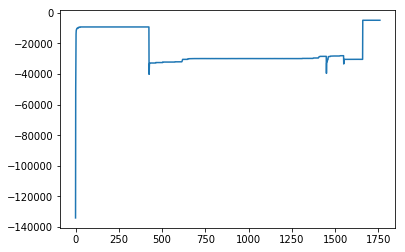

In [590]:
sampler.plot()

In [588]:
sampler.rho = dg.perturbation
sampler.Z = dg.cell_types
sampler.beta = dg.initial_cell_carac

In [521]:
from collections import defaultdict

In [523]:
def sample(sampler, n_samples = 10):
    res = defaultdict(list)
    for _ in range(n_samples):
        sampler.train(25, expression)
        res["rho"].append(sampler.rho)
        res["beta"].append(sampler.beta)
        res["z"].append(sampler.Z)
        res["pi"].append(sampler.pi)
    for k in res:
        res[k] = np.array(res[k])
    return res
    

In [591]:
s = sample(sampler, 10)

In [552]:
from scipy.stats import mode

In [571]:
clusters_pred = mode(s["z"], axis=0).mode[0]

In [572]:
groundtruth = dg.cell_types

In [573]:
groundtruth

array([1, 1, 2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1,
       1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2,
       2, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 0, 2, 2, 0, 1,
       0, 2, 0, 0, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2,
       0, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1,
       0, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 2, 1,
       0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 1, 0, 1, 0, 2, 0, 1, 1, 2, 2, 2,
       1, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0,
       2, 2, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 2, 1, 2,
       1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 1, 2, 0,
       1, 0, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0,
       2, 2, 0, 2, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 1,

In [574]:
clusters_pred

array([1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [533]:
from sklearn.metrics import normalized_mutual_info_score

In [536]:
normalized_mutual_info_score(clusters_pred, groundtruth)

/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1.0

In [538]:
np.random.seed(2)
dg = DataGenerator(n_cells, n_cell_types, n_genes, K, epsilon)
    

In [540]:
score = []
for epsilon in np.linspace(0, 2, 20):
    expression = dg.generate_gene_expression(epsilon, n_cells)
    sampler = GibbsSampler(n_cells, n_cell_types, n_genes, 10, 1, epsilon, dg.graph, dg.graph_reversed)
    sampler.train(100, expression)
    
    s = sample(sampler, 10)
    clusters_pred = mode(s["z"], axis=0).mode[0]
    groundtruth = dg.cell_types
    score.append(normalized_mutual_info_score(clusters_pred, groundtruth, average_method='geometric'))
    print(epsilon, score[-1])
    

/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.0 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.10526315789473684 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.21052631578947367 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.3157894736842105 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.42105263157894735 1.0


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.5263157894736842 0.4771673250494859


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.631578947368421 0.7567895510026084


/home/achille/miniconda3/envs/scvi-update/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.7368421052631579 0.352292898493842


KeyboardInterrupt: 

array([[1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1]])

In [592]:
s["rho"].std(axis=0)[1,1]

array([0.86975205, 1.14438111, 2.19133842, 1.39400151, 1.28254947,
       0.71119764])

In [593]:
s["rho"].mean(axis=0)[1,1]

array([-11.94664252,  19.9109246 ,  20.41798479,  -3.59231231,
         7.56142889,  -0.15291544])

In [594]:
dg.perturbation[1,1]

array([-18.68090655,  17.31184666,  14.67678011,  -3.35677339,
         6.1134078 ,   0.47970592])

In [83]:
sampler.Z

array([1, 1, 1, 0, 1, 0, 2, 1, 2, 0])

In [84]:
dg.cell_types

array([0, 0, 0, 1, 0, 1, 2, 0, 2, 1])

In [74]:
gs = GibbsSamplerO(expression, 3)

In [75]:
gs.run_gibbs(100)

[-3401.748983306175,
 -54.916211294836316,
 -51.59809172499874,
 -49.07265200216855,
 -56.10167814061352,
 -51.52813875663723,
 -53.81353752714547,
 -54.606687248189786,
 -52.557764608237086,
 -59.16501729772925,
 -47.61986065806933,
 -55.77690676399175,
 -55.3966444221681,
 -49.58302740791405,
 -52.84935263562221,
 -50.48625987901906,
 -54.081470862860755,
 -55.036087668050484,
 -58.95000326025008,
 -49.91075351089705,
 -56.758703165533475,
 -49.40577401900014,
 -51.58808436325172,
 -53.670682669272885,
 -59.967954526825984,
 -53.44730879971517,
 -51.34973788039145,
 -50.30806285483588,
 -55.170031077681266,
 -51.86715520231809,
 -52.114049391170774,
 -48.757991692402314,
 -51.87268754151549,
 -55.332945275087994,
 -51.571922911028494,
 -49.802607168480726,
 -54.79065614218608,
 -59.74482858127561,
 -53.517063519974975,
 -53.93223384348598,
 -51.78100695461344,
 -53.62428786472539,
 -52.077436537071975,
 -50.116266137424574,
 -50.580928371281246,
 -52.5916317685823,
 -53.9527699096377

In [76]:
gs.latent_variables[]

{'theta': array([0.17824664, 0.28579064, 0.53596272]), 'z': array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]]), 'beta': array([[ -4.39083358,   0.0798692 ,  -8.57207756,   0.2591827 ,
          -5.23157991],
        [-13.41583285,   7.95059077,   9.18353537,  14.98887881,
           1.45680536],
        [ 17.40763078,   3.76452611,   1.82834145, -18.50243235,
          -3.90154086]])}

In [73]:
from functools import lru_cache


@lru_cache(4096)
def log_fact(k):
    if k >= 4090:
        raise Exception("Value too big for our cache system")
    if k < 0:
        raise ValueError
    if k <= 1:
        return 1
    
    return log_fact(k - 1) + np.log(k)

for i in range(1,4090):
    log_fact(i)


class GibbsSamplerO:
    def __init__(self, x, n_cat=5):
        self.n_obs, self.dim_obs = x.shape
        self.n_cat = n_cat
        self.x = x

        self.hyperparameters = {
            "dirich": np.array([1] * self.n_cat),
            "sigma": 1,
            "lambda": 10
        }

        self.latent_variables = dict()
        self.latent_variables["theta"] = np.random.dirichlet(
            self.hyperparameters["dirich"]
        )
        self.latent_variables["z"] = np.random.multinomial(
            1, [1 / self.n_cat] * n_cat, self.n_obs
        )
        self.latent_variables["beta"] = np.random.uniform(0,10, (self.n_cat, self.dim_obs))

    def log_density_x_cond_z(self, x, z):
        beta_z = self.latent_variables["beta"][z]
        log_proba = 0
        for xk, bk in zip(x, beta_z):
            log_proba += - (xk-bk)**2
        return log_proba

    def sample_zi(self, i):
        log_densities = np.array(
            [
                self.log_density_x_cond_z(self.x[i], k) 
                for k in range(self.n_cat)
            ]
        )
        log_proportions = log_densities + np.log(self.latent_variables["theta"])
        log_normalizing_constant = np.logaddexp.reduce(log_proportions)
        log_proportions -= log_normalizing_constant
        proportions = np.exp(log_proportions)
        return np.random.multinomial(1, proportions)

    def sample_beta_k(self, k):
        sigma2 = self.hyperparameters['sigma']**2
        lambda2 = self.hyperparameters['lambda']**2
        cluster = self.x[self.latent_variables["z"][:, k].astype(bool)]
        if len(cluster) == 0:
            return np.random.normal(0, lambda2)
        nk = len(cluster)
        muk = nk/sigma2 / (nk/sigma2 + 1/lambda2) * cluster.mean(axis=0)
        lambdak = 1/(nk/sigma2 + 1/lambda2)
        
        return np.random.normal(muk, lambdak**0.5)
        
    def sample_theta(self):
        alpha = self.hyperparameters["dirich"]
        z_counts = self.latent_variables["z"].sum(axis=0)
        return np.random.dirichlet(alpha + z_counts)

    def one_epoch(self):
        for i in range(self.n_obs):
            self.latent_variables["z"][i] = self.sample_zi(i)
        self.latent_variables["theta"] = self.sample_theta()
        for k in range(self.n_cat):
            self.latent_variables["beta"][k] = self.sample_beta_k(k)

    def evaluate_log_joint(self):
        # Log theta 
        alpha = self.hyperparameters['dirich']
        log_theta = (np.log(self.latent_variables['theta'])*(alpha-1)).sum()
        
        # Log beta k
        beta = self.latent_variables['beta']
        log_b = - np.sum(beta**2/(2*self.hyperparameters['lambda']**2))
        
        # Log z i
        theta = self.latent_variables['theta']
        log_z = np.sum(np.log(theta)*self.latent_variables['z'])
        
        # Log x_i
        z = self.latent_variables['z']
        betax = self.latent_variables['beta'][z.argmax(axis=1)]
        log_x = -np.sum((self.x - betax)**2)/(2*self.hyperparameters['sigma']**2)
        
        return log_x + log_z + log_b + log_theta
    
    
            
    def run_gibbs(self, n_epochs=100):
        hist = []
        hist.append(self.evaluate_log_joint())
        for i in range(n_epochs):
            self.one_epoch()
            hist.append(self.evaluate_log_joint())
        return hist